In [1]:
url = "https://www.cdslab.org/DMC2021F/exam/1-problem/points.txt"

In [2]:
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt 
import numpy as np

In [3]:
#downloads file from given url
def download(url, fpath):
    import requests
    r = requests.get(url)
    with open(fpath, 'wb') as f:
        f.write(r.content)
    return None

#fetching data file
def fetchDatafromWeb(filePath,url):
    download(url,filePath)
    return filePath

In [4]:
fetchDatafromWeb(filePath="./points.txt", url=url)

'./points.txt'

In [5]:
df=pd.read_csv("./points.txt")
df

,x,y
0,9.345086,8.635191
1,9.549745,8.358315
2,9.485531,8.594657
3,9.591068,8.487629
4,9.472495,8.604223
...,...,...
995,4.562102,5.085064
996,4.525696,5.121790
997,4.557869,5.072882
998,4.651561,5.107200


In [6]:
# read data
Point = np.array([df.x,df.y]) #[[x],[y]]

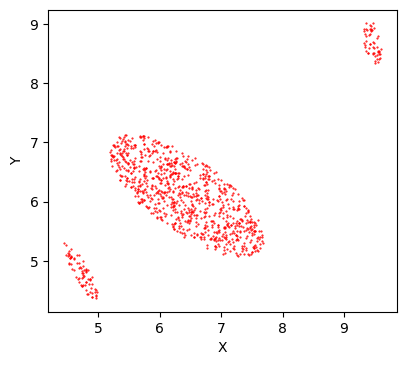

In [7]:
#%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# read data
Data = pd.read_csv("points.txt")
Point = np.array([Data.x,Data.y])

fig = plt.figure( figsize=(4.5, 4) \
                , dpi= 100 \
                , facecolor='w' \
                , edgecolor='w' \
                ) # create figure object
ax = fig.add_subplot(1,1,1) # Get the axes instance

ax.plot( Point[0,:] \
       , Point[1,:] \
       , 'r.' \
       , markersize = 1 \
       ) # plot with color red, as line

ax.set_xlabel('X')
ax.set_ylabel('Y')
fig.savefig('points.png', dpi=200) # save the figure to an external file
plt.show() # display the figure

In [8]:
#gives ellipsoid center
def getMinVolPartition(Point):
    import numpy as np
    npoint = len(Point[0,:]) #len of x array -- 1000
    ndim = len(Point[:,0]) #num of vars --2
    ncMax = npoint // (ndim + 1) # max number of clusters possible
    BoundingEllipsoidCenter = np.array([np.mean(Point[0,:]),np.mean(Point[1,:])])
    SampleCovMat = np.mat(np.cov(Point))
    SampleInvCovMat = np.mat(np.linalg.inv(SampleCovMat))
    PointNormed = np.mat(np.zeros((ndim,npoint)))
    for idim in range(ndim):
        #x - x.mean : y - y.mean
        PointNormed[idim,:] = Point[idim] - BoundingEllipsoidCenter[idim]
    MahalSq = PointNormed.T * SampleInvCovMat * PointNormed
    maxMahalSq = np.max(MahalSq)
    BoundingEllipsoidVolume = np.linalg.det(SampleCovMat) * maxMahalSq**ndim
    BoundingEllipsoidCovMat = SampleCovMat * maxMahalSq
    print(
    """
    nd = {}
    np = {}
    ncMax = {}
    SampleCovMat = {}
    InvCovMat = {}
    max(MahalSq) = {}
    BoundingEllipsoidCenter = {}
    BoundingEllipsoidCovMat = {}
    BoundingEllipsoidVolume = {}
    """.format( ndim
              , npoint
              , ncMax
              , SampleCovMat[:]
              , SampleInvCovMat
              , maxMahalSq
              , BoundingEllipsoidCenter
              , BoundingEllipsoidCovMat
              , BoundingEllipsoidVolume
              ))
    return BoundingEllipsoidCenter, BoundingEllipsoidCovMat

In [9]:
becenter, becovmat = getMinVolPartition(Point)
#2 data objects: center of ellipsoid, and cov matrix o f center 


    nd = 2
    np = 1000
    ncMax = 333
    SampleCovMat = [[1.0761723  0.36394188]
 [0.36394188 0.71635847]]
    InvCovMat = [[ 1.12198982 -0.5700206 ]
 [-0.5700206   1.68554491]]
    max(MahalSq) = 14.185346024371288
    BoundingEllipsoidCenter = [6.44826263 6.14296536]
    BoundingEllipsoidCovMat = [[15.26587652  5.16264153]
 [ 5.16264153 10.16179275]]
    BoundingEllipsoidVolume = 128.47580579408634
    


In [10]:
def getRandMVU(numRandMVU,MeanVec,CovMat,isInside=True):
    """
    generates numRandMVU uniformly-distributed random points from 
    inside an ndim-dimensional ellipsoid with Covariance Matrix CovMat, 
    centered at MeanVec[0:ndim].
    Output:
        Numpy matrix of shape numRandMVU by ndim
    """
    import numpy as np
    ndim = len(MeanVec)
    AvgStdMVN = np.zeros(ndim)
    CovStdMVN = np.eye(ndim)
    RandStdMVN = np.random.multivariate_normal(AvgStdMVN,CovStdMVN,numRandMVU)
    DistanceSq = np.sum(RandStdMVN**2, axis=1)
    #print(len(DistanceSq))
    if isInside:
        UnifRnd = np.random.random((numRandMVU,))
        UnifRnd = (UnifRnd**(1./ndim)) / np.sqrt(DistanceSq)

    CholeskyLower = np.linalg.cholesky(np.mat(CovMat))
    #print(CholeskyLower[1,0])
    RandMVU = np.zeros(np.shape(RandStdMVN))
    for iRandMVU in range(numRandMVU):
        if isInside:
            RandStdMVN[iRandMVU] *= UnifRnd[iRandMVU]
        else:
            RandStdMVN[iRandMVU] /= np.sqrt(DistanceSq[iRandMVU])
        for i in range(ndim):
            RandMVU[iRandMVU,i] = RandMVU[iRandMVU,i] + CholeskyLower[i,i] * RandStdMVN[iRandMVU,i]
            for j in range(i+1,ndim):
                RandMVU[iRandMVU,j] = RandMVU[iRandMVU,j] + CholeskyLower[j,i] * RandStdMVN[iRandMVU,i]
        RandMVU[iRandMVU] += MeanVec
    return RandMVU


    nd = 2
    np = 1000
    ncMax = 333
    SampleCovMat = [[1.0761723  0.36394188]
 [0.36394188 0.71635847]]
    InvCovMat = [[ 1.12198982 -0.5700206 ]
 [-0.5700206   1.68554491]]
    max(MahalSq) = 14.185346024371288
    BoundingEllipsoidCenter = [6.44826263 6.14296536]
    BoundingEllipsoidCovMat = [[15.26587652  5.16264153]
 [ 5.16264153 10.16179275]]
    BoundingEllipsoidVolume = 128.47580579408634
    


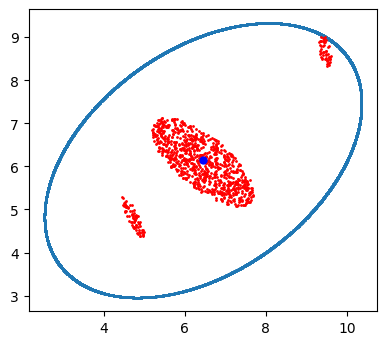

In [11]:
MeanVec, CovMat = getMinVolPartition(Point)
RandMVU = getRandMVU( numRandMVU=10000
                    , MeanVec=MeanVec
                    , CovMat=CovMat
                    , isInside = False
                    )
#%matplotlib notebook
import matplotlib.pyplot as plt

fig = plt.figure( figsize=(4.5, 4) \
                , dpi= 100 \
                , facecolor='w' \
                , edgecolor='w' \
                ) # create figure object

# plot the points
plt.plot( Point[0,:] \
        , Point[1,:] \
        , 'r.' \
        , markersize = 2 \
        )

# plot the center point
plt.plot( MeanVec[0] \
        , MeanVec[1] \
        , 'b.' \
        , markersize = 10 \
        )

# plot the bounding ellipsoid
plt.scatter(RandMVU[:,0],RandMVU[:,1],1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

# attempt

In [12]:
from sklearn.cluster import KMeans

In [13]:
def get_minvol(Point):
    import numpy as np
    npoint = len(Point[0,:]) #len of x array -- 1000
    ndim = len(Point[:,0]) #num of vars --2
    ncMax = npoint // (ndim + 1) # max number of clusters possible
    BoundingEllipsoidCenter = np.array([np.mean(Point[0,:]),np.mean(Point[1,:])])
    SampleCovMat = np.mat(np.cov(Point))
    SampleInvCovMat = np.mat(np.linalg.inv(SampleCovMat))
    PointNormed = np.mat(np.zeros((ndim,npoint)))
    for idim in range(ndim):
        #x - x.mean : y - y.mean
        PointNormed[idim,:] = Point[idim] - BoundingEllipsoidCenter[idim]
    MahalSq = PointNormed.T * SampleInvCovMat * PointNormed
    maxMahalSq = np.max(MahalSq)
    BoundingEllipsoidVolume = np.linalg.det(SampleCovMat) * maxMahalSq**ndim
    BoundingEllipsoidCovMat = SampleCovMat * maxMahalSq
    
    return BoundingEllipsoidCenter, BoundingEllipsoidCovMat

def get_boundary(Point, nRandMVU):
    
    
    eMeanVec, eCovMat = get_minvol(Point.T)
    area = np.sqrt(np.linalg.det(eCovMat))
    eRandMVU = getRandMVU( numRandMVU= nRandMVU
                        , MeanVec=eMeanVec
                        , CovMat=eCovMat
                        , isInside = False
                        )
        
    
    return eMeanVec,eRandMVU, area
     

In [14]:
def get_cluster(df, k, nRandMVU):
    ndf=df.copy()
    
    # read data
    Point = np.array([ndf.x,ndf.y]) #[[x],[y]]
    
    #get kmean labels
    Memb = KMeans( n_clusters = k 
                          , random_state= 544
                          , init ="k-means++"
                          , n_init= 100
                          , max_iter =300
                          , tol =0.001 #how much center can change by
                       ).fit_predict(Point.T)
    #add to dframe
    ndf["id"] = Memb.tolist()
    #change format to a dict -- key cluster: value points
    cluster_group = {}
    for indx in ndf.id.value_counts().index:
        #if indx in ndf.id.values:
            a = ndf.loc[ndf['id'] == indx] 
            na = np.array (np.transpose([a.x,a.y]))
            
            eMeanVec,eRandMVU, eArea = get_boundary(na, nRandMVU)
            cluster_group[indx] = (np.array(np.transpose([a.x,a.y])),eMeanVec,eRandMVU,eArea)
    
    return cluster_group
    


In [15]:
def get_plot(df, k=None, pts=None):
    
    if type(df) == dict:
        testing = df
        knum= len(df)
    else:
        testing = get_cluster(df, k=k, nRandMVU=pts)
        knum= len(testing)
        #key cluster: pts, eMean, eRandMVU, eArea
    a=[]
    m=[]
    for i in testing.keys():
        
        Points = testing[i][0].T
        eMeanVec = testing[i][1]
        eRandMVU = testing[i][2]
        eArea = testing[i][3]

        # plot the points
        plt.plot( Points[0,:] \
                , Points[1,:] \
                , 'k.' \
                , markersize = 2 \
                )

        # plot the center point
        plt.plot( eMeanVec[0] \
                , eMeanVec[1] \
                , 'r.' \
                , markersize = 10 \
                )

        # plot the bounding ellipsoid
        plt.scatter(eRandMVU[:,0],eRandMVU[:,1],1)
      
        #printing ellipsoids centers and areas
        m.append(eMeanVec)
        a.append(eArea)
        
    plt.show()
    print("Bounding Ellipsoid(s):")   
    print("""
            Number of clusters = {}
            Center = {}
            Area = {}
            """.format(knum 
                      , m
                      , a
         ))
    return a

In [16]:
def get_next(df,two_ellipsoid, nRandMVU ):    
    
    kept=[]
    keep={}
    print("Ellipsoids to evaluate:")
    get_plot(two_ellipsoid)
    for i,val in two_ellipsoid.items():
        print("\n Evaluating ellipsoid of cluster {}:\n".format(i))
        ndf = pd.DataFrame(two_ellipsoid[i][0], columns=["x","y"])
        area = two_ellipsoid[i][3]
        A = get_plot(ndf, k=2, pts= nRandMVU)

        if area > np.sum(A):
            #keep.append(A)
            print("Area of previous single ellipsoid is bigger. Continue with two ellipsoids...")
            new_2_ellipsoids= get_cluster(ndf,k=2,nRandMVU=1000)
            for e,val in new_2_ellipsoids.items():
                kept.append(new_2_ellipsoids[e])
            #keep_e.append(new_2_ellipsoids[e][0] for e,val in new_2_ellipsoids.items())
        else:
            #keep.append(area)
            print("Area of previous single ellipsoid is smaller. Keep previous single ellipsoid..")
            #keep_e.append(pts)
            kept.append(two_ellipsoid[i])
    for i in range(len(kept)):
        keep[i]=kept[i]
    return keep

In [17]:
single_ellipsoid  = get_cluster(df,k=1,nRandMVU=1000)

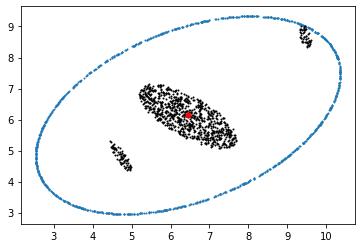

Bounding Ellipsoid(s):

            Number of clusters = 1
            Center = [array([6.44826263, 6.14296536])]
            Area = [11.334716837843212]
            


[11.334716837843212]

In [18]:
get_plot(single_ellipsoid)

In [19]:
two_ellipsoid  = get_cluster(df,k=2,nRandMVU=1000)

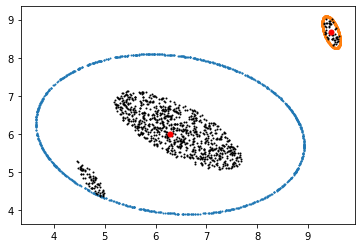

Bounding Ellipsoid(s):

            Number of clusters = 2
            Center = [array([6.2798622 , 6.00156419]), array([9.45722894, 8.66951079])]
            Area = [5.470123114966253, 0.06118556211113149]
            


[5.470123114966253, 0.06118556211113149]

In [20]:
#returns area
get_plot(two_ellipsoid)

Ellipsoids to evaluate:


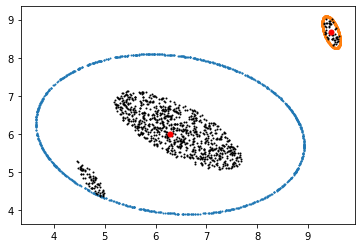

Bounding Ellipsoid(s):

            Number of clusters = 2
            Center = [array([6.2798622 , 6.00156419]), array([9.45722894, 8.66951079])]
            Area = [5.470123114966253, 0.06118556211113149]
            

 Evaluating ellipsoid of cluster 1:



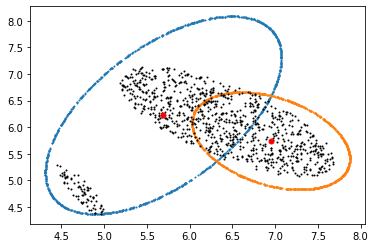

Bounding Ellipsoid(s):

            Number of clusters = 2
            Center = [array([5.69253573, 6.22699062]), array([6.95090262, 5.74400685])]
            Area = [2.08411709002879, 0.7848052431488576]
            
Area of previous single ellipsoid is bigger. Continue with two ellipsoids...

 Evaluating ellipsoid of cluster 0:



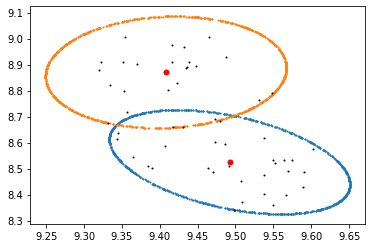

Bounding Ellipsoid(s):

            Number of clusters = 2
            Center = [array([9.49213992, 8.52615106]), array([9.4080362 , 8.87151768])]
            Area = [0.028709549496543203, 0.034026058568571986]
            
Area of previous single ellipsoid is smaller. Keep previous single ellipsoid..


In [21]:
new_ellipsoids = get_next(df, two_ellipsoid, nRandMVU=1000)

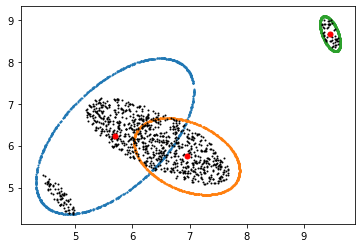

Bounding Ellipsoid(s):

            Number of clusters = 3
            Center = [array([5.69253573, 6.22699062]), array([6.95090262, 5.74400685]), array([9.45722894, 8.66951079])]
            Area = [2.08411709002879, 0.7848052431488576, 0.06118556211113149]
            


[2.08411709002879, 0.7848052431488576, 0.06118556211113149]

In [22]:
get_plot(new_ellipsoids)

Ellipsoids to evaluate:


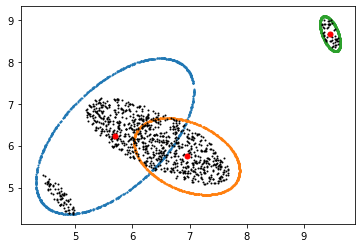

Bounding Ellipsoid(s):

            Number of clusters = 3
            Center = [array([5.69253573, 6.22699062]), array([6.95090262, 5.74400685]), array([9.45722894, 8.66951079])]
            Area = [2.08411709002879, 0.7848052431488576, 0.06118556211113149]
            

 Evaluating ellipsoid of cluster 0:



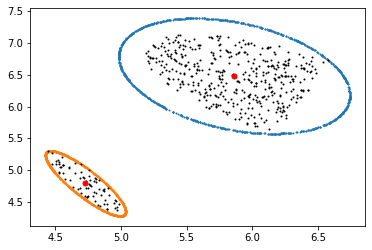

Bounding Ellipsoid(s):

            Number of clusters = 2
            Center = [array([5.86286614, 6.48137373]), array([4.73106537, 4.79106487])]
            Area = [0.7514744638362117, 0.07837840262711454]
            
Area of previous single ellipsoid is bigger. Continue with two ellipsoids...

 Evaluating ellipsoid of cluster 1:



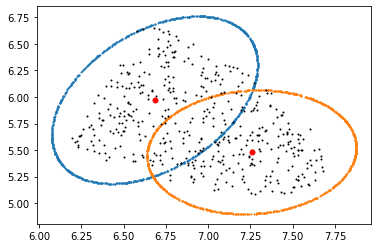

Bounding Ellipsoid(s):

            Number of clusters = 2
            Center = [array([6.68410881, 5.97277776]), array([7.25654989, 5.48191978])]
            Area = [0.4351513701797263, 0.3600642359597543]
            
Area of previous single ellipsoid is smaller. Keep previous single ellipsoid..

 Evaluating ellipsoid of cluster 2:



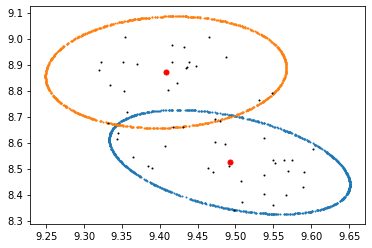

Bounding Ellipsoid(s):

            Number of clusters = 2
            Center = [array([9.49213992, 8.52615106]), array([9.4080362 , 8.87151768])]
            Area = [0.028709549496543203, 0.034026058568571986]
            
Area of previous single ellipsoid is smaller. Keep previous single ellipsoid..


In [23]:
new_new_ellipsoids = get_next(df, new_ellipsoids, nRandMVU=1000)

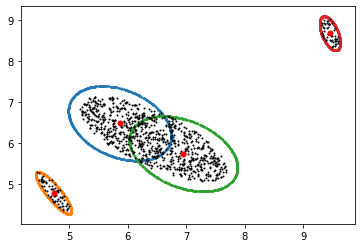

Bounding Ellipsoid(s):

            Number of clusters = 4
            Center = [array([5.86286614, 6.48137373]), array([4.73106537, 4.79106487]), array([6.95090262, 5.74400685]), array([9.45722894, 8.66951079])]
            Area = [0.7514744638362117, 0.07837840262711454, 0.7848052431488576, 0.06118556211113149]
            


[0.7514744638362117,
 0.07837840262711454,
 0.7848052431488576,
 0.06118556211113149]

In [24]:
get_plot(new_new_ellipsoids)

Ellipsoids to evaluate:


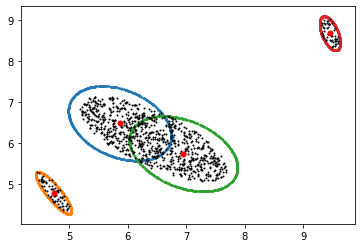

Bounding Ellipsoid(s):

            Number of clusters = 4
            Center = [array([5.86286614, 6.48137373]), array([4.73106537, 4.79106487]), array([6.95090262, 5.74400685]), array([9.45722894, 8.66951079])]
            Area = [0.7514744638362117, 0.07837840262711454, 0.7848052431488576, 0.06118556211113149]
            

 Evaluating ellipsoid of cluster 0:



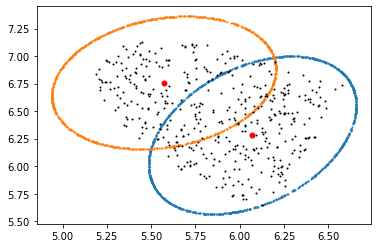

Bounding Ellipsoid(s):

            Number of clusters = 2
            Center = [array([6.07150635, 6.28247273]), array([5.5714692 , 6.75916843])]
            Area = [0.38870525742633893, 0.3733744170208898]
            
Area of previous single ellipsoid is smaller. Keep previous single ellipsoid..

 Evaluating ellipsoid of cluster 1:



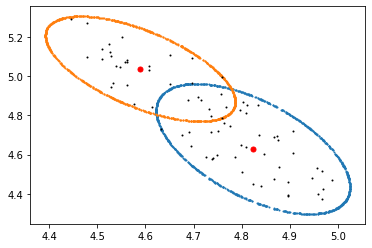

Bounding Ellipsoid(s):

            Number of clusters = 2
            Center = [array([4.82359035, 4.62960044]), array([4.58919374, 5.03864367])]
            Area = [0.05422621727515536, 0.041068059715869666]
            
Area of previous single ellipsoid is smaller. Keep previous single ellipsoid..

 Evaluating ellipsoid of cluster 2:



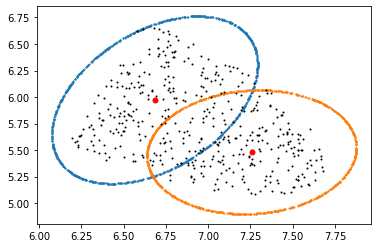

Bounding Ellipsoid(s):

            Number of clusters = 2
            Center = [array([6.68410881, 5.97277776]), array([7.25654989, 5.48191978])]
            Area = [0.4351513701797263, 0.3600642359597543]
            
Area of previous single ellipsoid is smaller. Keep previous single ellipsoid..

 Evaluating ellipsoid of cluster 3:



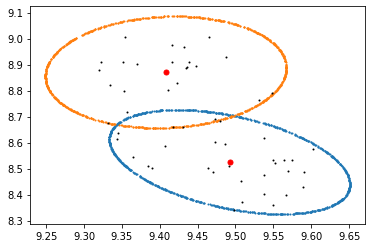

Bounding Ellipsoid(s):

            Number of clusters = 2
            Center = [array([9.49213992, 8.52615106]), array([9.4080362 , 8.87151768])]
            Area = [0.028709549496543203, 0.034026058568571986]
            
Area of previous single ellipsoid is smaller. Keep previous single ellipsoid..


In [25]:
stopping = get_next(df, new_new_ellipsoids, nRandMVU=1000)

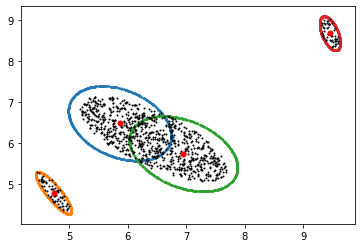

Bounding Ellipsoid(s):

            Number of clusters = 4
            Center = [array([5.86286614, 6.48137373]), array([4.73106537, 4.79106487]), array([6.95090262, 5.74400685]), array([9.45722894, 8.66951079])]
            Area = [0.7514744638362117, 0.07837840262711454, 0.7848052431488576, 0.06118556211113149]
            


[0.7514744638362117,
 0.07837840262711454,
 0.7848052431488576,
 0.06118556211113149]

In [26]:
get_plot(stopping)

"new_new_ellipsoids" same as "stopping".  This implies all of the child-ellipsoids have been found